## Importing modules:

In [1]:
import os 
import damask
import numpy as np

In [13]:
num_case = 1

height = 128
width = 128

num_grain = 10
directory_simulation = 'simulation_size=128_grains=10'


In [7]:
pwd()

'/nethome/storage/raid2/m.khorrami/files/ML_elasticity_v2'

## Creating directories for case studies:

In [8]:
if not os.path.exists(directory_simulation):
        os.mkdir(directory_simulation)

for case in range(0,num_case):
        if not os.path.exists(directory_simulation+'/case_'+str(case)):
                os.mkdir(directory_simulation+'/case_'+str(case)) 

# for case in range(0,num_case):
#     os.makedirs(directory_simulation+'/case_'+str(case))

## Creating geometries for each case studies:

In [9]:
size = np.array([2.0,float(height),float(width)])
cells = [2,int(height),int(width)]

for case in range(0,num_case):
    seeds = damask.seeds.from_random(size,num_grain,cells) # no modification on seeds
    grid = damask.Grid.from_Voronoi_tessellation(cells,size,seeds)
    grid.save(directory_simulation+'/case_'+str(case)+'/geom_'+str(case))

# case = 0

# g1 = damask.Grid(np.zeros((2,64,64),int), np.array([2.0,64.0,64.0]))
# g1 = g1.add_primitive(np.array([32,32.0,32.0]),np.array([1.0,32.0,32.0]),1)
# g1.save(directory_simulation+'/case_'+str(case)+'/geom_'+str(case))

# g2 = damask.Grid(np.zeros((2,64,64),int), np.array([2.0,64.0,64.0]))
# g2 = g2.add_primitive(np.array([4.0,32.0,32.0]),np.array([1.0,32.0,32.0]),200)
# g2.save(directory_simulation+'/case_'+str(case)+'/geom_'+str(case))
# g2.show()
# print(g2)

Defining functions: 

1 - calculating C_11, C_12, and C_44 from E and v (elasticity)

2 - making phases for material.yaml (material configuration of DAMASK)

3 - making material.yaml

In [10]:
def E_v_to_C(E,v):
    C_11 = E / ((1 + v) * (1 - 2 * v)) * (1 - v)
    C_12 = E / ((1 + v) * (1 - 2 * v)) * v
    C_44 = E / ((1 + v) * (1 - 2 * v)) * (1 - 2 * v)
    return C_11, C_12, C_44

def make_phase(file_name, C_11, C_12, C_44, Y, h, gamma_0):
    file = open(file_name,'w+')
    file.write('lattice: cF\n')
    file.write('mechanical:\n')
    file.write('    output: [F, P]\n')
    file.write('    elastic: {type: Hooke, C_11: '+str(C_11)+', C_12: '+str(C_12)+', C_44: '+str(C_44)+'}\n')
    # file.write('    plastic:\n')
    # file.write('        type: isotropic\n')
    # file.write('        xi_0: '+str(Y)+'\n')
    # file.write('        xi_inf: '+str(Y*1e30)+'\n')
    # file.write('        dot_gamma_0: '+str(gamma_0)+'\n')
    # file.write('        n: '+str(20)+'\n')
    # file.write('        M: '+str(1.0)+'\n')
    # file.write('        h_0: '+str(h)+'\n')
    # file.write('        a: '+str(1.0))
    file.close()
    return None

def make_config_material(directory):
    config_material = damask.ConfigMaterial()
    config_material['homogenization']['SX'] = {'N_constituents':1,'mechanical':{'type':'pass'}}
    for grain in range(0,num_grain):
        config_material = config_material.material_add(phase=['phase_'+str(grain)], O=[1,0,0,0], homogenization='SX')
    for grain in range(0,num_grain):
        config_material['phase']['phase_'+str(grain)] = damask.ConfigMaterial.load(directory+'/grain_'+str(grain)+'.yaml')
    config_material.save(directory+'/material.yaml')
    return None

## Creating case studies:
making grains and material configurations

In [11]:
E_min = 50  # in GPa
E_max = 300 # in GPa
v_min = 0.2
v_max = 0.4
Y_min = 50  # in MPa
Y_max = 300 # in MPa
h_min = 0   # in GPa
h_max = 50  # in GPa

for case in range(0,num_case):
    file_properties_grains = open(directory_simulation+'/case_'+str(case)+'/properties_grain','w+')
    for grain in range(0,num_grain):
        E = np.random.uniform(E_min,E_max)*1e9
        v = np.random.uniform(v_min,v_max)
        Y = np.random.uniform(Y_min,Y_max)*1e6
        h = np.random.uniform(h_min,h_max)*1e9
        # E = 100*1e9
        # v = 0.3
        # Y = 200*1e6
        # h = 50*1e9
        gamma_0 = 0.001
        # if grain==0:
        #     E = E_min*1e9*1.05
        #     v = v_min*1.05
        #     Y = Y_min*1e6*1.05
        #     h = h_min*1e9*1.05
        # if grain==1:
        #     E = E_max*1e9*0.95
        #     v = v_max*0.95
        #     Y = Y_max*1e6*0.95
        #     h = h_max*1e9*0.95
        # in each line: E, v, Y, h
        # file_properties_grains.write(str(E)+' '+str(v)+' '+str(Y)+' '+str(h)+'\n')
        file_properties_grains.write(str(E)+' '+str(v)+'\n')
        C_11, C_12, C_44 = E_v_to_C(E,v)
        make_phase(directory_simulation+'/case_'+str(case)+'/grain_'+str(grain)+'.yaml', C_11, C_12, C_44, Y, h, gamma_0)
    file_properties_grains.close()
    make_config_material(directory_simulation+'/case_'+str(case))

## Running DAMASK:

It is strongly recommended ro run this cell in a seperate python script and use "nohup python3 running_DAMASK.py".

In [5]:

#os.system('export PETSC_DIR=/home/kourosh/petsc-3.14.2')
#os.system('export PETSC_ARCH=arch-linux-c-opt')
# os.system('source /home/kourosh/damask-3.0.0-alpha7/env/DAMASK.zsh')
os.environ['OMP_NUM_THREADS'] = '8'

for case in range(0,num_case):
    os.chdir(directory_simulation+'/case_'+str(case))
    # os.system('DAMASK_grid --load ../../tensionZ.yaml --geom geom_'+str(case)+'.vti')
    os.system('mpirun -np 2 DAMASK_grid --load ../../tensionZ.yaml --geom geom_'+str(case)+'.vti')
    os.chdir('../../')

## Post-processing
* calculating sigma and sigma_vM from output damask, hdf5 file
* It is strongly recommende to run this cell in a seperate python script and use "nohup python3 post_processing_vM.py".

In [ ]:
# # setting unlimitting open files 
# os.system('ulimit -s unlimited')
# os.system('export HDF5_USE_FILE_LOCKING=FALSE')

# # calculating sigma and sigma_vM:
# # num_case = 1
# for case in range(0,num_case):
#     print('case: '+str(case)+'\n')
#     res = damask.Result(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'_tensionZ.hdf5')
#     res.add_stress_Cauchy()
#     res.add_equivalent_Mises('sigma')
#     # res.export_VTK()

In [6]:
from numba import jit, njit, prange, vectorize
import numpy as np
import damask

# num_case = 1
num_inc = 20

# sigma_vM = np.zeros((num_case,num_inc+1,int(height),int(width)))
sigma_vM = np.zeros((num_case,int(height),int(width)))

@jit(nopython=True, parallel=True)
def calc_sigma_vM(F, P):
    sigma_vM_ = np.zeros(height*width)
    for i in prange(0,height*width):
                J = np.linalg.det(F[i,:,:])
                # sigma = np.dot(P[i,:,:],np.transpose(F[i,:,:])/J)
                sigma = P[i,:,:]@np.transpose(F[i,:,:])/J
                sigma_vM_[i] = np.sqrt(((sigma[0,0]-sigma[1,1])*(sigma[0,0]-sigma[1,1])+(sigma[1,1]-sigma[2,2])*(sigma[1,1]-sigma[2,2])+
                                    (sigma[2,2]-sigma[0,0])*(sigma[2,2]-sigma[0,0])+6*(sigma[0,1]*sigma[0,1]+sigma[1,2]*sigma[1,2]+sigma[2,0]*sigma[2,0]))/2)
    return sigma_vM_

In [13]:
P_ = res.place('P')
F_

 ██████████████████████████████████████████████████ 100% ETA 0:00:00


()

In [14]:
from numba import prange

# for case in prange(0,num_case):
#     print('case: '+str(case)+'\n')
#     res = damask.Result(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'_tensionZ.hdf5')
#     F_ = res.place('F')
#     P_ = res.place('P')
#     for inc in prange(0,num_inc+1):
#         F = np.reshape(F_['increment_'+str(inc)].data, (2,64,64,3,3), order='F')
#         P = np.reshape(P_['increment_'+str(inc)].data, (2,64,64,3,3), order='F')
#         F = np.reshape(F[0,:,:,:,:],(4096,3,3), order = 'F')
#         P = np.reshape(P[0,:,:,:,:],(4096,3,3), order = 'F')
#         sigma_vM[case,inc,:,:] = np.reshape(calc_sigma_vM(F, P),(64,64), order='F')

last_inc = 20

# P11 = np.zeros((int(height),int(width), num_case))
P22 = np.zeros((int(height),int(width), num_case))
P23 = np.zeros((int(height),int(width), num_case))
P32 = np.zeros((int(height),int(width), num_case))
P33 = np.zeros((int(height),int(width), num_case))

# directory_simulation = "../ML_elasticity/simulation2/"

for case in prange(0,num_case):
    print('case: '+str(case)+'\n')
    res = damask.Result(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'_tensionZ.hdf5')
    F_ = res.place('F')
    P_ = res.place('P')
    F = np.reshape(F_['increment_'+str(last_inc)].data, (2,height,width,3,3), order='F')
    P = np.reshape(P_['increment_'+str(last_inc)].data, (2,height,width,3,3), order='F')
    # F = np.reshape(F[0,:,:,:,:],(height*width,3,3), order = 'F')
    # P = np.reshape(P[0,:,:,:,:],(height*width,3,3), order = 'F')
    # sigma_vM[case,:,:] = np.reshape(calc_sigma_vM(F, P),(64,64), order='F')
    # P11[:,:,case] = P[0,:,:,0,0]
    P22[:,:,case] = P[0,:,:,1,1]
    P23[:,:,case] = P[0,:,:,1,2]
    P32[:,:,case] = P[0,:,:,2,1]
    P33[:,:,case] = P[0,:,:,2,2]

# np.save(directory_simulation+'/P11',P11)

# directory_simulation = "./simulation/"
np.save(directory_simulation+'/P22',P22)
np.save(directory_simulation+'/P23',P23)
np.save(directory_simulation+'/P32',P32)
np.save(directory_simulation+'/P33',P33)

 ████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  10% ETA 0:00:01

case: 0



 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


## Finding maximum of sigma_vM:

In [8]:
# # vM_max = 851656527.9795784 * 1e-6
# num_increment = 20
# # num_case = 1

# for case in range(0,num_case):
#     print('case: '+str(case)+'\n')
#     res = damask.Result(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'_tensionZ.hdf5')
#     vM = res.place('sigma_vM')
#     for inc in range(0,num_increment+1):
#         vM_max = np.max([np.max(vM[ 'increment_'+str(inc)]),vM_max])

# sigma_vM = np.load(directory_simulation+'/sigma_vM.npy')

# vM_max = np.max(sigma_vM)

# print('vM_max: ' + str(vM_max))

# P31 = np.load(directory_simulation+'/P31.npy')
P32 = np.load(directory_simulation+'/P32.npy', allow_pickle=True)
P33 = np.load(directory_simulation+'/P33.npy')

# P31_max = np.max(P31)
P32_max = np.max(P32)
P33_max = np.max(P33)

# P31_min = np.min(P31)
P32_min = np.min(P32)
P33_min = np.min(P33)

# print(P31_max)
print(P32_max)
print(P33_max)

# print(P31_min)
print(P32_min)
print(P33_min)

P_max = np.max([P32_max,P33_max])
P_min = np.max([P32_min,P33_min])


FileNotFoundError: [Errno 2] No such file or directory: 'simulation2/P31.npy'

## Creating input/output pictures (bmp files) for machine learning:

In [15]:
# from PIL import Image
import damask
import numpy as np
import os

# if not os.path.exists(directory_simulation+'/inputs'):
#         os.mkdir(directory_simulation+'/inputs')

# if not os.path.exists(directory_simulation+'/outputs'):
#         os.mkdir(directory_simulation+'/outputs')

# vM_max = 851656527.9795784

E_min = 50 *1e9  # in Pa
E_max = 300 *1e9 # in Pa
v_min = 0.2
v_max = 0.4
Y_min = 50 *1e6 # in Pa
Y_max = 300 *1e6 # in Pa
h_min = 0 *1e9  # in Pa
h_max = 50 *1e9 # in Pa

# os.makedirs('inputs')
# os.makedirs('outputs')

# width = 64
# height = 64

# num_case = 1
# num_increment = 20
# num_grain = 10


# def make_picture(data, minimum, maximum, directory, width=64, heigh=64):
#     data_normalized = np.round((data - minimum) / (maximum - minimum) * 255.0)
#     im = Image.new('L', [width, heigh])
#     im.putdata(data_normalized.flatten())
#     im = im.save(directory)
#     return None

# for case in range(0,num_case):
#     print('case: '+str(case)+'\n')
#     # res = damask.Result(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'_tensionZ.hdf5')
#     # vM = res.place('sigma_vM') # vM[ 'increment_'+str(inc)]
#     # for inc in range(0,num_increment+1):
#     #     # data = np.reshape(vM['increment_'+str(inc)].data, [2, width, height],order='F')
#     #     make_picture(sigma_vM[case,inc], 0.0, vM_max, directory_simulation+'/outputs/vM_'+str(case)+'_'+str(inc)+'.bmp')
#     make_picture(P32[case], P32_min, P32_max, directory_simulation+'/outputs/P32_'+str(case)+'.bmp')
#     make_picture(P33[case], P33_min, P33_max, directory_simulation+'/outputs/P33_'+str(case)+'.bmp')

E_array = np.zeros((width, height, num_case))
v_array = np.zeros((width, height, num_case))

# directory_simulation = "../ML_elasticity/simulation2/"

for case in range(0,num_case):
    print('case: '+str(case)+'\n')
    grid = damask.Grid.load(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'.vti')
    material_ids = grid.material[0,:,:]
    file_properties = open(directory_simulation+'/case_'+str(case)+'/properties_grain','r')
    lines = file_properties.readlines()
    E_all = np.zeros((width,height))
    v_all = np.zeros((width,height))
    # Y_all = np.zeros((width,height))
    # h_all = np.zeros((width,height))
    for grain in range(0,num_grain):
        E_all = E_all + float(lines[grain].split()[0]) * (material_ids==grain)
        v_all = v_all + float(lines[grain].split()[1]) * (material_ids==grain)
        # Y_all = Y_all + float(lines[grain].split()[2]) * (material_ids==grain)
        # h_all = h_all + float(lines[grain].split()[3]) * (material_ids==grain)
    # make_picture(E_all, E_min, E_max, directory_simulation+'/inputs/E_'+str(case)+'.bmp')
    # make_picture(v_all, v_min, v_max, directory_simulation+'/inputs/v_'+str(case)+'.bmp')
    # make_picture(Y_all, Y_min, Y_max, directory_simulation+'/inputs/Y_'+str(case)+'.bmp')
    # make_picture(h_all, h_min, h_max, directory_simulation+'/inputs/h_'+str(case)+'.bmp')
    E_array[:,:,case] = E_all
    v_array[:,:,case] = v_all

# directory_simulation = "./simulation/"
np.save(directory_simulation+'/E',E_array)
np.save(directory_simulation+'/v',v_array)

case: 0



In [16]:
case = 0
res = damask.Result(directory_simulation+'/case_'+str(case)+'/geom_'+str(case)+'_tensionZ.hdf5')
P = res.place('P')


 ██████████████████████████████████████████████████ 100% ETA 0:00:00


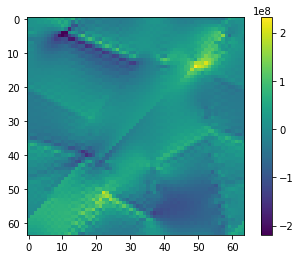

In [20]:
# vM_20 = vM['increment_20']
# vM_20 = sigma_vM[0,20,:,:]

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# vM_reshaped = np.reshape(vM_20,(2,64,64),order='F')
for inc in range(0,1):
    plt.imshow(P32[0,:,:],cmap=mpl.colormaps['viridis'])
    plt.colorbar()
    plt.show()

Text(0.5, 0, '$F_{33}$')

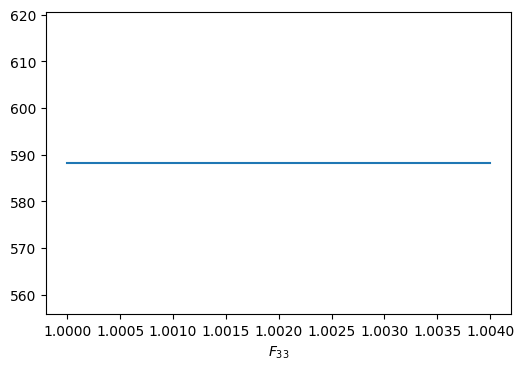

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

num_inc = 20
F_33 = 1 + np.linspace(0,0.004,num_inc+1)
ave_vM = np.zeros_like(F_33)
for inc in range(0,num_inc+1):
    ave_vM[inc] = np.average(sigma_vM[0,inc])*1e-6

plt.figure(1,dpi=100)
plt.plot(F_33,ave_vM)
plt.xlabel('$F_{33}$')